In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Data Prepration for LSTM

* In this notebook LSTM is used for forecasting future sales. 
* The type of the LSTM can be regarded as Multivariate and Multiple Input Series (Multi-step is not used).
* The model is trained using past sales values for each 30490 item and a feature which represents if there exists an event at the following day.  
* For this notebook "sales of past 14 days and event feature" are used for predicting 15th day sales. Past days is a parameter which can be set to see the effect. 

* Below timesteps is set to 14 to use past 14 days' sales.
* Since there are lots of zero values in first days, "startDay" parameter can be used ignore unwanted days from the beginning.

In [ ]:
dataPath = "/kaggle/input/m5-forecasting-accuracy/"
timesteps = 14
startDay = 350

In [ ]:
dt = pd.read_csv(dataPath + "/sales_train_validation.csv")
dt.head(3)


In [ ]:
print(dt.info())

In [ ]:
#To reduce memory usage
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [ ]:
#Reduce memory usage and compare with the previous one to be sure
dt = downcast_dtypes(dt)

In [ ]:
print(dt.info())

* The shape of the data is not exactly what we want.
* We want to have each day as row and 30490 items' sales as columns (features)
* Therefore take the transpose of "dt"

In [ ]:
#Take the transpose so that we have one day for each row, and 30490 items' sales as columns
dt = dt.T    
dt.head(8)

* Remove the first six  colums id, item_id, dept_id, cat_id, store_id, state_id columns, to end up only days as rows

In [ ]:
#Remove id, item_id, dept_id, cat_id, store_id, state_id columns
dt = dt[6 + startDay:]
dt.head(5)

In [ ]:
calendar = pd.read_csv(dataPath + "/calendar.csv")


* Here a dataframe is created to store the knowledge if an event exist in the next day
* Firstly, fill with zeros the dataframe

In [ ]:
#Create dataframe with zeros for 1969 days in the calendar
daysBeforeEvent = pd.DataFrame(np.zeros((1969,1)))


* Now, "1" is assigned the day before an event exist. Other days will remain as "0".

In [ ]:
# "1" is assigned to the days before the event_name_1. Since "event_name_2" is rare, it was not added.
for x,y in calendar.iterrows():
    if((pd.isnull(calendar["event_name_1"][x])) == False):
           daysBeforeEvent[0][x-1] = 1 
            #if first day was an event this row will cause an exception because "x-1".
            #Since it is not i did not consider for now.

   

In [ ]:
#"calendar" won't be used anymore. 
del calendar


* Since, the "daysBeforeEvent" feature is used for predicting after the model trained as input, we seperate the 28 days as "daysBeforeEventTest"
* For training the first 1914 days (if "startDay" is zero otherwise "1913-startDay") will be used.

In [ ]:
#"daysBeforeEventTest" will be used as input for predicting (We will forecast the days 1913-1941)
daysBeforeEventTest = daysBeforeEvent[1913:1941]
#"daysBeforeEvent" will be used for training as a feature.
daysBeforeEvent = daysBeforeEvent[startDay:1913]



In [ ]:
#Before concatanation with our main data "dt", indexes are made same and column name is changed to "oneDayBeforeEvent"
daysBeforeEvent.columns = ["oneDayBeforeEvent"]
daysBeforeEvent.index = dt.index



* Concatenate "daysBeforeEvent" feature with our main dataframe "dt"

In [ ]:
dt = pd.concat([dt, daysBeforeEvent], axis = 1)

dt.columns

In [ ]:
#Feature Scaling
#Scale the features using min-max scaler in range 0-1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dt_scaled = sc.fit_transform(dt)

* Here is the important part. "X_train" and "y_train" data is created. For each X_train item, 14 past days' sales and 14 daysBeforeEvent feature are included. So one element of X_train's shape is (14, 30491). For y_train we are predicting one day sales of 30490 items therefore one element of y_train's shape is (1, 30490)

In [ ]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay):
    X_train.append(dt_scaled[i-timesteps:i])
    y_train.append(dt_scaled[i][0:30490]) 
    #İmportant!! if extra features are added (like oneDayBeforeEvent) 
    #use only sales values for predictions (we only predict sales) 
    #this is why 0:30490 columns are choosen

Creation of X_train and y_train
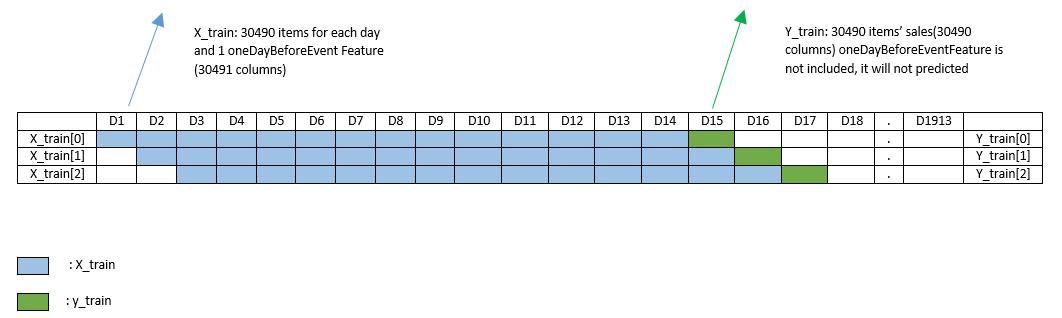

In [ ]:
del dt_scaled


In [ ]:
#Convert to np array to be able to feed the LSTM model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

# LSTM Model with Keras

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
layer_2_units=400
regressor.add(LSTM(units = layer_2_units, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 30490))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=32
batch_size_RNN=44
regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size_RNN)



* Take last days, 14 for this notebook ("timestep" parameter) in order to predict firts unknown day's sales.
* Before using values for prediction, again use min-max transformation

In [ ]:
inputs= dt[-timesteps:]
inputs = sc.transform(inputs)

* Here is again an important part. 
* We are using last 14 days in order to predict day 1915 sales.
* In order to predict 1916th day, 13 days from our input data and 1 day from our prediction are used. After that we slide the window one by one.
    * 12 days from input data + 2 days from our prediction to predict 1917th day
    * 11 days from input data + 3 days from our prediction to predict 1918th day
    * .....
    * 14 days our prediction to predict last 1941th day sales.

In [ ]:
X_test = []
X_test.append(inputs[0:timesteps])
X_test = np.array(X_test)
predictions = []

for j in range(timesteps,timesteps + 28):
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = regressor.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 30491))
    testInput = np.column_stack((np.array(predicted_stock_price), daysBeforeEventTest[0][1913 + j - timesteps]))
    X_test = np.append(X_test, testInput).reshape(1,j + 1,30491)
    predicted_stock_price = sc.inverse_transform(testInput)[:,0:30490]
    predictions.append(predicted_stock_price)

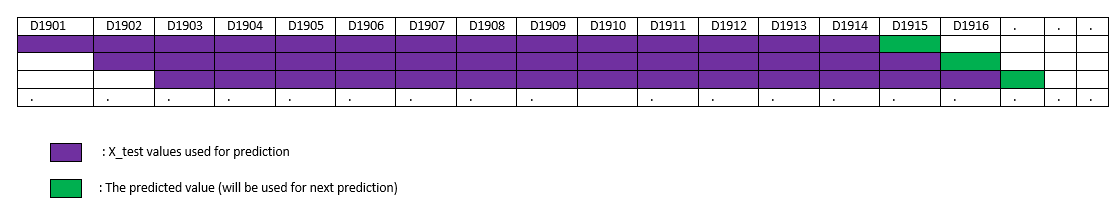

# Submission File Creation
* Here, the submission file creation is done.

In [ ]:
import time

submission = pd.DataFrame(data=np.array(predictions).reshape(28,30490))

submission = submission.T
    
submission = pd.concat((submission, submission), ignore_index=True)

sample_submission = pd.read_csv(dataPath + "/sample_submission.csv")
    
idColumn = sample_submission[["id"]]
    
submission[["id"]] = idColumn  

cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]

colsdeneme = ["id"] + [f"F{i}" for i in range (1,29)]

submission.columns = colsdeneme

currentDateTime = time.strftime("%d%m%Y_%H%M%S")

submission.to_csv("submission.csv", index=False)

# Future Improvements
* Here only sales of past days and oneDayBeforeEvent feature are used for prediction. More feature can be added.
    * Maybe, lag features, sell prices can be included. But including those features for each item can increase the column size from 30491 to 60981 maybe more. Any ideas for feature addition are very welcome. I could not find a proper way to add those kind of features.
* Data preprocessing may be applied. There are lots of zero values especially in the first year. But I could not find a way how to deal with them. In addition, outliers can be handled if any, especially if sell prices data is used.
* Multi-step LSTM can be used for prediction of more than one day (for example 28 days at once or 14 days, 7 days, 2 days etc.)
* Choosing correct neuron sizes, batch size and layer size can be achieved.
* Each run can create different results. I did not add seed value but may be this can be added. I have wanted to see how much the result differs
* You can share any ideas for improvement as a comment, we can discuss more detail